## Import

In [5]:
import pandas as pd
import requests
import string
string.punctuation
import re
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from transformers import pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize   
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.dates as mdate

import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec


from sklearn.model_selection import(
    cross_val_score,
    train_test_split,
    GridSearchCV
)

from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
from datetime import timezone
import datetime

pd.set_option('display.max_colwidth', None)

## Data importing and Cleaning

In [6]:
df_ptsd1 = pd.read_csv('Data/PTSD.csv')
df_ptsd2 = pd.read_csv('Data/PTSD2.csv')

In [7]:
df_ptsd1.shape

(10122, 7)

In [8]:
df_ptsd2.shape

(10122, 6)

In [9]:
# to create df_ptsd 
df_ptsd = pd.concat([df_ptsd1, df_ptsd2[['link_flair_css_class']]], axis = 1)
print(df_ptsd.shape)

(10122, 8)


In [10]:
df_anxiety = pd.read_csv('Data/Anxiety.csv')

df_anxiety = df_anxiety.drop(columns = 'Unnamed: 0')
df_ptsd.drop(columns = 'Unnamed: 0', inplace = True)

df = pd.concat([df_ptsd,df_anxiety])
df.reset_index(inplace = True)
df.drop(columns = 'index', inplace = True)

In [11]:
df_ptsd2['link_flair_css_class'].unique()

array(['advice', 'discussion', 'support', 'success', 'venting', nan,
       'meta', 'resource'], dtype=object)

In [12]:
# both subreddits has venting as their filter 
df_anxiety['link_flair_css_class'].unique()

array(['relationshipflair', 'adviceneeded', 'daeflair', 'venting',
       'schoolflair', 'articleflair', 'books', 'medsflair', 'helpflair',
       'lovedones', 'healthflair', 'discussion', 'amapost',
       'introductions', 'helpfultips', 'victory-recurring', nan,
       'drivingflair', 'progressflair', 'trigger', 'artflair',
       'relaxingimgs', 'announcements', 'studyflair'], dtype=object)

In [13]:
df.shape

(20229, 7)

In [14]:
# create all text column for self text and title combined 

df['alltext'] = df['selftext'] + ' ' + df['title']

In [15]:
# to create calculate length of text and title 

df['length_text'] = df['alltext'].map(lambda x: len(x))

In [16]:
# to create calculate status word cout of text and title 
tokenizer = RegexpTokenizer('\s+', gaps=True)

def tokenizer_func(text):
    return len(tokenizer.tokenize(text))

df['wrdcount_text'] = df['alltext'].apply(lambda x: tokenizer_func(x))

In [17]:
# define function to remove punctuation and remove \n
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    punctuationfree = ' '.join([sentence for sentence in punctuationfree.split('\n') if sentence != ''])
    return punctuationfree

df['clean_text'] = df['alltext'].apply(lambda x: x.lower())   
df['clean_text']= df['clean_text'].apply(lambda x: remove_punctuation(x))   

In [18]:
# found NAN coming from the link filter
df.isnull().sum()

author                   0
subreddit                0
selftext                 0
title                    0
created_utc              0
datetime                 0
link_flair_css_class    73
alltext                  0
length_text              0
wrdcount_text            0
clean_text               0
dtype: int64

In [19]:
# drop rows that has no link to any sub flair
df.dropna(inplace = True)

In [20]:
unique_counts = pd.DataFrame(df.groupby('author')['subreddit'].count())
unique_counts.reset_index(inplace = True)
unique_counts

,author,subreddit
0,---Scotty---,1
1,--A-lost-soul--,1
2,--Eug--,1
3,--Nature--,1
4,-7hr0w4w4y-,1
...,...,...
13514,zwitterion76,1
13515,zylonrave,1
13516,zynopsis61,1
13517,zzfailureloser123,1


In [21]:
# To create one column called ttl_post to append total number of post for each user
# TO BE USED ONLY using unique_users dataframe below 
df = df.merge(unique_counts, on = 'author')
df.rename(columns = {'subreddit_x': 'subreddit', 'subreddit_y': 'ttl_post'}, inplace = True)

In [22]:
# change Ptsd to 1 and Anxiety to 0

df['subreddit'] = df['subreddit'].map(lambda x: 1 if x == 'ptsd' else 0)

In [23]:
# Converting 'created_utc' column from epoch time to datetime object.

df['datetime'] = df['created_utc'].map(lambda ts: datetime.datetime.fromtimestamp(ts))

In [24]:
# Find difference in terms of days from first post till last post 
def find_earliest_date(col):
    author = col
    max = df[df['author'] == author]['created_utc'].max()
    min = df[df['author'] == author]['created_utc'].min()    
    return (pd.to_datetime(max, unit = 's').to_pydatetime() - pd.to_datetime(min, unit = 's').to_pydatetime()).days

# apply function to create column for duration from last post 
# to be used only using unique_users dataframe below 

df['duration_last_post'] = df['author'].apply(lambda x: find_earliest_date(x)).fillna(0)

In [25]:
# to create reference list for identify columns with ptsd/anxiety or both
unique_list_for_ptsd = df[df['subreddit'] == 1]['author'].unique().tolist()
unique_list_for_anxiety = df[df['subreddit'] == 0]['author'].unique().tolist()


# def function that labels  ptsd_only, anxiety_only , both

def identify_users(user):
    if (user in unique_list_for_ptsd) & (user not in unique_list_for_anxiety):
        return 'ptsd_only'

    elif (user not in unique_list_for_ptsd) & (user in unique_list_for_anxiety):
        return 'anxiety_only'

    else:
        return 'both'


df['user_contribute_where'] = df['author'].apply(identify_users)

In [26]:
# checking shape of unique df
pd.DataFrame(df['author'].unique())

,0
0,chicken_soup67
1,Rose_David163
2,leahjeank
3,ExchangePowerful3225
4,misstasia
...,...
13514,kotek96
13515,temp225566
13516,YungLedge
13517,soulflooo


In [27]:
# create separate data frame to consist of only unique users 
unique_users = pd.DataFrame(df['author'].unique())
unique_users = pd.concat([unique_users,df], axis = 1).dropna()
unique_users.drop(columns = 0, inplace = True)

In [28]:
# creating main dataframe for two separate subreddits
ptsd = df[df['subreddit'] == 1]
anxiety = df[df['subreddit'] == 0]
anxiety.reset_index(inplace = True)
anxiety = anxiety.drop(columns = 'index')

## Exploratory Data Analysis

### Visualising Differences in subreddit's activity levels

In [29]:
ptsd_user = len(df[df['user_contribute_where'] == 'ptsd_only']['author'].unique())
anxiety_user = len(df[df['user_contribute_where'] == 'anxiety_only']['author'].unique())
both_user = len(df[df['user_contribute_where'] == 'both']['author'].unique())

print(f'Number of users in r/PTSD only is {ptsd_user}')
print(f'Number of users in r/Anxiety only is {anxiety_user}')
print(f'Number of users in both subreddits is {both_user}')

print(f'Total number of unique users is {ptsd_user + anxiety_user + both_user}')

Number of users in r/PTSD only is 6189
Number of users in r/Anxiety only is 7238
Number of users in both subreddits is 92
Total number of unique users is 13519


Need to take note that there are 92 users who are using both subreddits, this may bring in ambiguity and inaccuracy as to whether or not these users has PTSD or not.

When modeling, we can consider removing accounts from these users, and recalculate accuracy

In [30]:
# creating focused dataframe to zoom into ALL USERS who are venting and belong to either one of the subreddits 
# this is to cater for only those who might be actually suffereing from either one of the groups 
df_all_users = df[(df['user_contribute_where'] != 'both')]

# To find out total length and word count per post for each subreddit groups
df_all_users.groupby(by = 'subreddit')[['length_text','wrdcount_text']].agg(['count', 'mean'])

length_text              wrdcount_text            
                count         mean         count        mean
subreddit                                                   
0                9890   854.188473          9890  161.837715
1                9916  1154.311214          9916  217.402884

Text(0.5, 1.0, 'Scatterplot showing number of length of text on both subreddits')

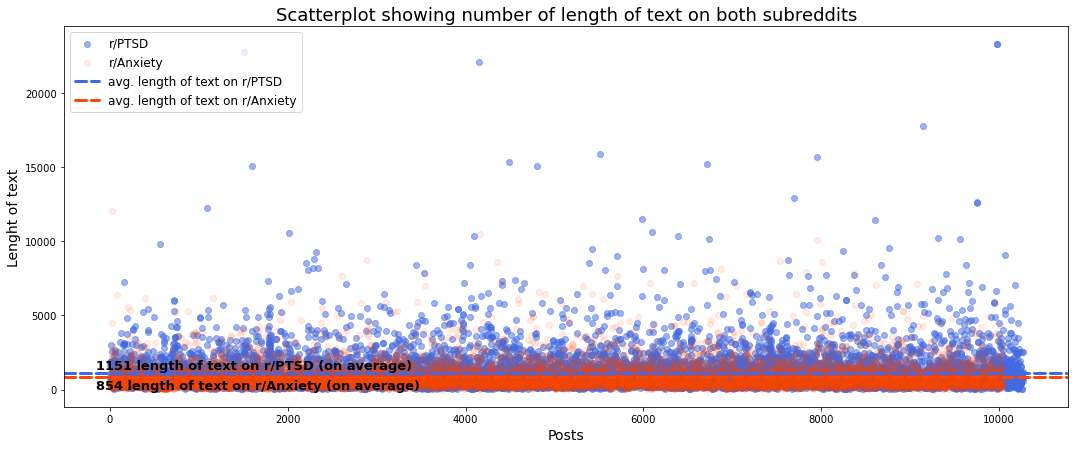

In [31]:
# Plotting scatterplot to show no. of length of text on both subreddits.

fig, ax = plt.subplots(figsize=(18,7))

plt.scatter(ptsd.index, ptsd['length_text'], color='royalblue', alpha=0.5, label='r/PTSD')
plt.scatter(anxiety.index, anxiety['length_text'], color='orangered', alpha=0.1, label='r/Anxiety')

# Plotting horizontal lines to show average no. of words for posts in both subreddits.
plt.axhline(ptsd['length_text'].mean(),
            label='avg. length of text on r/PTSD',
            ls='--',
            linewidth=3,
            color='royalblue',
            dash_capstyle='round',
           )
plt.figtext(x=0.15,
            y=0.20,
            s=f"{int(round(ptsd['length_text'].mean(), 0))} length of text on r/PTSD (on average)",
            fontsize=13,
            fontweight='semibold'
           )

plt.axhline(anxiety['length_text'].mean(),
            label='avg. length of text on r/Anxiety',
            ls='--',
            linewidth=3,
            color='orangered',
            dash_capstyle='round',
           )
plt.figtext(x=0.15,
            y=0.16,
            s=f"{int(round(anxiety['length_text'].mean(), 0))} length of text on r/Anxiety (on average)",
            fontsize=13,
            fontweight='semibold'
           )


plt.legend(fontsize=12)

plt.xlabel("Posts", fontsize=14)
plt.ylabel("Lenght of text", fontsize=14)

plt.title("Scatterplot showing number of length of text on both subreddits", loc='center', fontsize=18)

Generally the length of text, number of words and even total number of post per users is higher in r/PTSD than in r/Anxiety. 

To visualise more, we plot a scatterplot for that shows the average length of text on both subrredicts. On average, the length text for r/PTSD is 1146 while the length of text for r/Anxiety is 853. 

Also we can see majority of the high flyers are coming from users in r/PTSD. This shows that users in r/PTSD are definitely more active in the subreddit, suggesting they might have alot more to share through their experience before getting PTSD. 

As users who might be suffering from PTSD has more specific relation to trauma genericly, people who can relate more to these post, will likely to share their experiences/advice as to how to perhaps overcome such grave issues as compared to having assumingly generic anxiety. 

### Exploring common word used in both subreddits

In [47]:
df.columns

Index(['author', 'subreddit', 'selftext', 'title', 'created_utc', 'datetime',
       'link_flair_css_class', 'alltext', 'length_text', 'wrdcount_text',
       'clean_text', 'ttl_post', 'duration_last_post', 'user_contribute_where',
       'clean2_text'],
      dtype='object')

In [69]:
ptsd_text = ptsd['clean_text']
ptsd_subreddit = ptsd['subreddit']

In [70]:
cvec = CountVectorizer()

cvec.fit(ptsd_text,ptsd_subreddit)
ptsd_text = cvec.transform(ptsd_text)


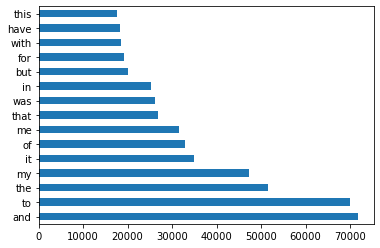

In [71]:
# show the 15 common words for r/PTSD
ptsd_df = pd.DataFrame(ptsd_text.todense(), 
                          columns=cvec.get_feature_names_out())

# plot top occuring words
ptsd_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');

In [73]:
anxiety_text = anxiety['clean_text']
anxiety_subreddit = anxiety['subreddit']

In [74]:
cvec.fit(anxiety_text,ptsd_subreddit)
anxiety_text = cvec.transform(anxiety_text)


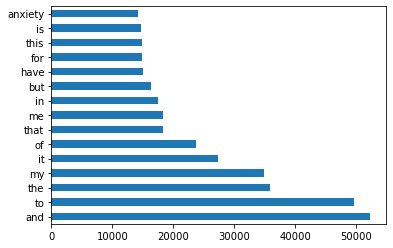

In [75]:
# show the 15 common words for r/PTSD
anxiety_df = pd.DataFrame(anxiety_text.todense(), 
                          columns=cvec.get_feature_names_out())

# plot top occuring words
anxiety_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');

The above words show that despite 

## Classification Modelling

In [34]:
# create stop word list 
stopwordlist = nltk.corpus.stopwords.words('english')

# to input in subreddit headers so that we can exclude it for model
headers = ['ptsd', 'anxiety',"cptsd", 'trauma','traumatized','traumas',"posttraumatic",'stress','disorder',"traumatic","'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would']
for head in headers:
    stopwordlist.append(head)

df['clean2_text'] = df['clean_text'].apply(lambda x: ' '.join([i for i in x.split() if i not in stopwordlist]))    

In [35]:
# assign target under subreddit, PTSD = 1, Anxiety = 0 

X = df['clean_text']
y = df['subreddit']

In [36]:
print(f'Total post: {len(df)}')
df['subreddit'].value_counts(normalize= True)


Total post: 20156


1    0.501885
0    0.498115
Name: subreddit, dtype: float64

With 10000 post added into each class, the classes are very well balanced from both sides 

Also, from the above, we can see the ***baseline accuracy*** is at 50.1%. 
If nothing ws done for the classification model, and just to assign every post to the PTSD class, i would classify 50.1% of the post correctly. 

Therefore, any classification model designed for this data must have an accuracy higher than the ***baseline accuracy*** of 50.1%

In [37]:
# Splitting the features and target variable datasets into training and testing datasets with stratify=y. 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

### Classification Metrics

Possible classification metrics that can be used how well my model perform are *Accuracy, Misclassification Rate, Sensitivity (True Positive Rate), Specificity (True Negative Rate), Precision (Positive Predictive Value), F1 Score and ROC AUC*.

For this project I will be mainly using *Accuracy* accompanied with confusion matrix to determine effectiveness of my models

For further evaluations, I will be using Specificity to choose the best model that helps gauge on how best to minimize this in order to reduce missing out identifying users potentionally having PTSD.

I will also use ROC to gave a gauge the degree of overlap between the words in post from the two subreddits. 

### Vectorization of words (CountVectorizer and TfidfVectorizer with LogisticRegression)

Consider two NLP vectorizers and iterate over parameters below with Logistic regression model first.
- *Count Vectorizer*
- *TF-IDF Vectorizer*

In [38]:
# Creating Pipeline with:
# Estimator: LogisticRegression (both)
# Transformer: CountVectorizer - pipe1, TfidfVectorizer - pipe2

pipe1 = Pipeline([('cvec1', CountVectorizer()),
                  ('logreg1', LogisticRegression())
                 ])

pipe2 = Pipeline([('tfvec2', TfidfVectorizer()),
                  ('logreg2', LogisticRegression())
                 ])

In [39]:
pipe2.get_params()

{'memory': None,
 'steps': [('tfvec2', TfidfVectorizer()), ('logreg2', LogisticRegression())],
 'verbose': False,
 'tfvec2': TfidfVectorizer(),
 'logreg2': LogisticRegression(),
 'tfvec2__analyzer': 'word',
 'tfvec2__binary': False,
 'tfvec2__decode_error': 'strict',
 'tfvec2__dtype': numpy.float64,
 'tfvec2__encoding': 'utf-8',
 'tfvec2__input': 'content',
 'tfvec2__lowercase': True,
 'tfvec2__max_df': 1.0,
 'tfvec2__max_features': None,
 'tfvec2__min_df': 1,
 'tfvec2__ngram_range': (1, 1),
 'tfvec2__norm': 'l2',
 'tfvec2__preprocessor': None,
 'tfvec2__smooth_idf': True,
 'tfvec2__stop_words': None,
 'tfvec2__strip_accents': None,
 'tfvec2__sublinear_tf': False,
 'tfvec2__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfvec2__tokenizer': None,
 'tfvec2__use_idf': True,
 'tfvec2__vocabulary': None,
 'logreg2__C': 1.0,
 'logreg2__class_weight': None,
 'logreg2__dual': False,
 'logreg2__fit_intercept': True,
 'logreg2__intercept_scaling': 1,
 'logreg2__l1_ratio': None,
 'logreg2__max_iter': 100

In [40]:
pipe1.get_params()

{'memory': None,
 'steps': [('cvec1', CountVectorizer()), ('logreg1', LogisticRegression())],
 'verbose': False,
 'cvec1': CountVectorizer(),
 'logreg1': LogisticRegression(),
 'cvec1__analyzer': 'word',
 'cvec1__binary': False,
 'cvec1__decode_error': 'strict',
 'cvec1__dtype': numpy.int64,
 'cvec1__encoding': 'utf-8',
 'cvec1__input': 'content',
 'cvec1__lowercase': True,
 'cvec1__max_df': 1.0,
 'cvec1__max_features': None,
 'cvec1__min_df': 1,
 'cvec1__ngram_range': (1, 1),
 'cvec1__preprocessor': None,
 'cvec1__stop_words': None,
 'cvec1__strip_accents': None,
 'cvec1__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec1__tokenizer': None,
 'cvec1__vocabulary': None,
 'logreg1__C': 1.0,
 'logreg1__class_weight': None,
 'logreg1__dual': False,
 'logreg1__fit_intercept': True,
 'logreg1__intercept_scaling': 1,
 'logreg1__l1_ratio': None,
 'logreg1__max_iter': 100,
 'logreg1__multi_class': 'auto',
 'logreg1__n_jobs': None,
 'logreg1__penalty': 'l2',
 'logreg1__random_state': None,
 'logreg1__

In [41]:
# Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

pipe1_params = {'cvec1__max_features': [1000, 2000, 3000],
                'cvec1__min_df': [0.02, 0.05],
                'cvec1__max_df': [0.7, 0.80],
                'cvec1__ngram_range': [(1,1), (1,2)],
                'logreg1__max_iter': [1000]
               }

pipe2_params = {'tfvec2__max_features': [1000,2000,3000],
                'tfvec2__min_df': [0.02, 0.05],
                'tfvec2__max_df': [0.7, 0.80],
                'tfvec2__ngram_range': [(1,1), (1,2)],
                'logreg2__max_iter': [1000]
               }

In [42]:
# Creating two separate GridSearchCV objects for:
# CountVectorizer and TfidfVectorizer

gs_pipe1 = GridSearchCV(pipe1, param_grid=pipe1_params, cv=5)

gs_pipe2 = GridSearchCV(pipe2, param_grid=pipe2_params, cv=5)

In [43]:
# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe1.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# Fitting GridSearchCV with TfidfVectorizer transformer on X_train and y_train.

gs_pipe2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfvec2', TfidfVectorizer()),
                                       ('logreg2', LogisticRegression())]),
             param_grid={'logreg2__max_iter': [1000],
                         'tfvec2__max_df': [0.7, 0.8],
                         'tfvec2__max_features': [1000, 2000, 3000],
                         'tfvec2__min_df': [0.02, 0.05],
                         'tfvec2__ngram_range': [(1, 1), (1, 2)]})

In [ ]:
# Best combination of hyperparameters suggested by GridSearchCV for CountVectorizer transformer.

gs_pipe1.best_params_

{'cvec1__max_df': 0.7,
 'cvec1__max_features': 1000,
 'cvec1__min_df': 0.02,
 'cvec1__ngram_range': (1, 1),
 'logreg1__max_iter': 1000}

In [ ]:
# Best combination of hyperparameters suggested by GridSearchCV for TfidfVectorizer transformer.

gs_pipe2.best_params_

{'logreg2__max_iter': 1000,
 'tfvec2__max_df': 0.7,
 'tfvec2__max_features': 1000,
 'tfvec2__min_df': 0.02,
 'tfvec2__ngram_range': (1, 1)}

In [ ]:
# Summary scores of CountVectorizer and LogisticRegression.

print("CountVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe1.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe1.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe1.score(X_test, y_test), 3)}")

CountVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.864

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.898
Testing corpus accuracy = 0.865


In [ ]:
# Summary scores of TfidfVectorizer and LogisticRegression.

print("TfidfVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe2.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe2.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe2.score(X_test, y_test), 3)}")

TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.868

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.89
Testing corpus accuracy = 0.87


In [ ]:
# Creacting a summary dataframe.

summary_df = pd.DataFrame(columns=['transformer_estimator', 
                                   'GS_best_params', 
                                   'GS_best_score', 
                                   'train_accuracy', 
                                   'test_accuracy'
                                  ])

In [ ]:
# Adding the accuracy scores from above two GridSearchCV models into summary_df.

summary_df.loc[1] = ['CountVec, LogReg',
                     'max_features=500, min_df=0.05, max_df=0.8, ngram_range=(1,2)',
                     round(gs_pipe1.best_score_, 3),
                     round(gs_pipe1.score(X_train, y_train), 3),
                     round(gs_pipe1.score(X_test, y_test), 3)
                    ]

summary_df.loc[2] = ['TfidfVec, LogReg',
                     'max_features=500, min_df=0.05, max_df=0.8, ngram_range=(1,1)',
                     round(gs_pipe2.best_score_, 3),
                     round(gs_pipe2.score(X_train, y_train), 3),
                     round(gs_pipe2.score(X_test, y_test), 3)
                    ]

In [ ]:
summary_df

,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,"CountVec, LogReg","max_features=500, min_df=0.05, max_df=0.8, ngram_range=(1,2)",0.864,0.898,0.865
2,"TfidfVec, LogReg","max_features=500, min_df=0.05, max_df=0.8, ngram_range=(1,1)",0.868,0.890,0.870


From the summary table, we can infer that the best combination of transformer hyperparameters to be 
- *max_features* = 500
- *min_df* = 0.05 
- *max_df* = 0.8 
- ngram_range=(1,2)	- for *tfidfVectorizer*

Judging solely on the accuracy scores, using **CountVectorizer** has very good accuracy on the training but did poorly on the testing corpus. This implies that this model is **overfitting on the training corpus**. 

On the other, using **TfidfVectorizer** transformer has better accuracy fir GSCV best score, and lesser delta between the train and test accuracy scores, suggesting that the **model may not be as overfitted than *CountVectorizer***

Therefore, I will use *TfidfVectorizer* for further classification model.



### TfidfVectorizer with MultinomialNB

There are 3 common types of Naive Bayes models: *Bernoulli Naive Bayes*, *Multinomial Naive Bayes*, and *Gaussian Naive Bayes*.

- [Bernoulli Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB): when we have 0/1 variables.
- [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB): when our variables are positive integers.
- [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB): when our features are Normally distributed.

We will be using ***MultinomialNB*** as it consideres a feature vector with all the individual words in a all post where a given term represent the number of times it appears. 

In [ ]:
# create pipe3 for transformer: TfidfVectorizer and estimator using MultinomialNB

pipe3 = Pipeline([('tfvec', TfidfVectorizer()),
                  ('nb', MultinomialNB())
                 ])

In [ ]:
# creating parameters for GridSearch SV using hyperparameters as shown below 
pipe3_params = {'tfvec__max_features': [2000,4000,6000],
                'tfvec__min_df': [0.001, 0.005, 0.01],
                'tfvec__max_df': [0.5,0.6,0.7],
                'tfvec__ngram_range': [(1,1)],
                'nb__alpha' : [1.0e-10]
}

In [ ]:
# Creatingg GridSeachCV using pipeline: pipe3 and params_grid:  pipe3_params

gs_pipe3 = GridSearchCV(pipe3, param_grid=pipe3_params, cv=5)

In [ ]:
# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [1e-10], 'tfvec__max_df': [0.5, 0.6, 0.7],
                         'tfvec__max_features': [2000, 4000, 6000],
                         'tfvec__min_df': [0.001, 0.005, 0.01],
                         'tfvec__ngram_range': [(1, 1)]})

In [ ]:
# Get best parameters using MultinomialNB and TfidfVectorizer

gs_pipe3.best_params_

{'nb__alpha': 1e-10,
 'tfvec__max_df': 0.7,
 'tfvec__max_features': 4000,
 'tfvec__min_df': 0.005,
 'tfvec__ngram_range': (1, 1)}

In [ ]:
# Summary scores of TfidfVectorizer and MultinomialNB.

print("TfidfVectorizer with MultinomialNB summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe3.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe3.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe3.score(X_test, y_test), 3)}")

TfidfVectorizer with MultinomialNB summary of accuracy scores:
GridSearchCV best accuracy = 0.845

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.859
Testing corpus accuracy = 0.852


In [ ]:
# adding summary 

summary_df.loc[3] = ['TfidfVec, MultinomialNB',
                     'max_features=500, min_df=0.05, max_df=0.8, ngram_range=(1,1)',
                     round(gs_pipe3.best_score_, 3),
                     round(gs_pipe3.score(X_train, y_train), 3),
                     round(gs_pipe3.score(X_test, y_test), 3)
                    ]

In [ ]:
summary_df

,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,"CountVec, LogReg","max_features=500, min_df=0.05, max_df=0.8, ngram_range=(1,2)",0.864,0.898,0.865
2,"TfidfVec, LogReg","max_features=500, min_df=0.05, max_df=0.8, ngram_range=(1,1)",0.868,0.890,0.870
3,"TfidfVec, MultinomialNB","max_features=500, min_df=0.05, max_df=0.8, ngram_range=(1,1)",0.845,0.859,0.852


TfidfVectorizer with MultinomialNB summary of accuracy scores:
GridSearchCV best accuracy = 0.844

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.85
Testing corpus accuracy = 0.853

In [ ]:
=

SyntaxError: invalid syntax (1763773627.py, line 1)

In [ ]:
# create stop word list 
stopwordlist = nltk.corpus.stopwords.words('english')

# to input in subreddit headers so that we can exclude it for model
headers = ['ptsd', 'anxiety',"cptsd", 'trauma','traumatized','traumas',"posttraumatic",'stress','disorder',"traumatic","'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would']
for head in headers:
    stopwordlist.append(head)


# Add additional list from stemmed words 

stemmed_data = ['abov', 'ani', 'anxieti', 'becaus', 'befor', 'disord', 'dure', 'hi', 'onc', 'onli', 'ourselv', 'posttraumat', 'themselv', 'thi', 'traumat', 'veri', 'whi', 'yourselv', 'becau','abov', 'ani', 'anxieti', 'becaus', 'befor', 'disord', 'dure', 'hi', 'onc', 'onli', 'ourselv', 'posttraumat', 'themselv', 'thi', 'traumat', 'veri', 'whi', 'yourselv']
for stem in stemmed_data:
    stopwordlist.append(stem)

stopwordlist


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
X = df['selftext']
y = df['subreddit']

#  Train test split 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwordlist)    


In [ ]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
clf = MultinomialNB(alpha=1.0)
clf.fit(X_train, y_train)

MultinomialNB()

In [ ]:
df['subreddit'].value_counts(normalize= True)

1    0.501885
0    0.498115
Name: subreddit, dtype: float64

In [ ]:
clf.predict(X_train)


array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

In [ ]:
vectorizer.get_feature_names()[0]

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


'00'

In [ ]:
# Test the prediction
# for first row, seeing prob of getting PTSD given using the word for 00 is higher than of given not PTSD
clf.predict_proba(X_train[0, :])


array([[0.26981468, 0.73018532]])

In [ ]:
df.shape

(20156, 15)

In [ ]:
# need to do todense() because after we vectorise, it is in a sparse matrix
# hence in order to read, we do todense

X_train.todense().shape

(13504, 28384)

In [ ]:
# two rows of probabilities 
# first is for 0 (NOT PTSD)
# second is for 1 (PTSD)

clf.feature_log_prob_.shape

(2, 28384)

In [ ]:
print(f'Log prob given not PTSD: {clf.feature_log_prob_[1, :]}') 

print(f'Log prob given PTSD: {clf.feature_log_prob_[0, :]}') 

Log prob given not PTSD: [-10.58027037 -10.4295882  -11.15760154 ... -11.22547512 -11.22547512
 -11.22547512]
Log prob given PTSD: [ -9.97178575 -10.30515788 -11.14866052 ... -10.8394678  -10.8394678
 -10.8394678 ]


In [ ]:
delta = clf.feature_log_prob_[1, :] - clf.feature_log_prob_[0, :]


df_multinomial = pd.DataFrame([[x,y] for x,y in zip(vectorizer.get_feature_names(),delta)])
df_multinomial.rename(columns= {0: 'Features', 1: 'log_prob_diff'}, inplace = True)
df_multinomial.sort_values(by = 'log_prob_diff', ascending = False).head(20)

,Features,log_prob_diff
10139,flashbacks,3.739169
20163,raped,3.289524
10136,flashback,3.233661
1050,abuser,3.165711
20162,rape,3.113196
2399,assault,3.109661
8674,emdr,2.860175
16909,nightmares,2.807720
1049,abused,2.801167
1048,abuse,2.774609


In [ ]:
X = df['selftext']
y = df['subreddit']

class LemmaTokenizer(object):
    def __init__(self):
        self.stem = PorterStemmer()
    def __call__(self,articles):
        return [self.stem.stem(t) for t in word_tokenize(articles)]


#  Train test split 
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

pipe = Pipeline([
    ('cvec', TfidfVectorizer(stop_words = stopwordlist, tokenizer= LemmaTokenizer())),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [1_000],
    'cvec__min_df': [.002],
    'cvec__max_df': [.6],
    'cvec__ngram_range': [(1,1), (1,2)],
}

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation

gs.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
gs.best_estimator_


Pipeline(steps=[('cvec',
                 TfidfVectorizer(max_df=0.6, max_features=1000, min_df=0.002,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<__main__.LemmaTokenizer object at 0x000001A52D6F7A60>)),
                ('nb', MultinomialNB())])

In [ ]:
# What's the best score?
print('Best score:', gs.best_score_)

# Score model on training set.
print('Best training score:', gs.score(X_train, y_train))
  
# Score model on testing set.
print('Best test score:', gs.score(X_test, y_test))

Best score: 0.800133475941695
Best training score: 0.8127221563981043
Best test score: 0.8027660853878533


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


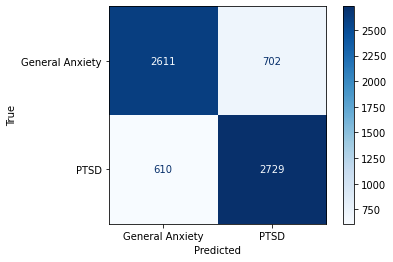

In [ ]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# View confusion matrix
cmd = plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d', display_labels=['General Anxiety','PTSD'])
cmd.ax_.set(xlabel='Predicted', ylabel='True');

In [ ]:
# to create delta between the log probabilities between two classes
delta = gs.best_estimator_[1].feature_log_prob_[1, :] - gs.best_estimator_[1].feature_log_prob_[0, :]

# Create Df and filter top few log prob 
df_multinomial = pd.DataFrame([[x,y] for x,y in zip(gs.best_estimator_[0].get_feature_names(), np.exp(delta))])
df_multinomial.rename(columns= {0: 'Features', 1: 'Probability_PTSD'}, inplace = True)
df_multinomial.sort_values(by = 'Probability_PTSD', ascending = False).head(30)


C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Features,Probability_PTSD
706,rape,53.554286
354,flashback,51.771695
102,assault,25.065286
291,emdr,20.328377
41,abus,17.095164
780,sexual,10.916288
609,nightmar,10.523782
938,victim,7.554709
181,childhood,6.226020
565,memori,6.138353


In [ ]:
def lemmetize_print(words):
     from nltk.stem import WordNetLemmatizer
     from nltk.tokenize import word_tokenize
     lemmatizer = WordNetLemmatizer()
     a = []
     tokens = word_tokenize(words)
     for token in tokens:
          if token in ['abused']:
              a.append('abuse')
          lemmetized_word = lemmatizer.lemmatize(token)
          a.append(lemmetized_word)
     sentence = " ".join(a)
     print(sentence)



text = 'flashbacks flashback abused'

lemmetize_print(text)

flashback flashback abuse abused


In [ ]:
stemmer = PorterStemmer()


def lemmetize_print(words):
     stemmer = PorterStemmer()
     a = []
     tokens = word_tokenize(words)
     for token in tokens:
          lemmetized_word = stemmer.stem(token)
          a.append(lemmetized_word)
     sentence = " ".join(a)
     print(sentence)


text = 'flashbacks flashback abuser'

lemmetize_print(text)

flashback flashback abus
